# HW#7 RNN

안녕하세요, 광운대학교 로봇학부의 오정현 교수입니다. 본 자료는 딥러닝 실습 수업을 위해 제작된 것입니다.

파이썬 문법
- 점프투파이썬(https://wikidocs.net/book/1) 참고

이번 과제는 딥러닝의 대표적인 구조인 Recurrent Neural Network (RNN)을 이용하여 주가 예측을 해보도록 하겠습니다. 이번 과제를 통해 부자가 되는 길(?)을 찾으면 좋겠네요.

#1. Data Import
Data는 finance-datareader를 통해서 가져올 수 있습니다. yahoo finance에서 제공하는 api를 확인 후 종목을 입력하면 해당 데이터를 불러옵니다. https://finance.yahoo.com/에 접속 후 상단에서 Finace를 선택한 후 원하는 종목을 검색하면 종목 코드를 알 수 있습니다. 종목 코드와 데이터를 가져올 시작 날짜와 끝 날짜를 입력하면 주가에 대한 데이터를 가져올 수 있습니다. 이 데이터는 `fdr.DataReader("종목코드", start="시작날짜", end ="끝날짜")` 함수를 통해 가져올 수 있습니다.

예시) naver 주식(035420.KS) 2000년 1월 1일부터 2010년 12월 31일까지 주가 정보 함수

fdr.DataReader("035420", start = "2000-01-01", end = "2010-12-31")

finace-datareader를 이용하기 위해서는 라이브러리를 다운 받아야 합니다. 아래의 코드를 실행해 다운받으면 됩니다. 

In [1]:
!pip install -U finance-datareader

다운이 완료되면 DataReader를 통해서 dataset을 생성하겠습니다. naver 주식 2000년 1월 1일부터 2010년 12월 31일까지 주가를 학습데이터로 활용하고 2011년 1월 1일부터 2020년 5월 31일까지 주가를 테스트데이터로 활용해 봅시다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import FinanceDataReader as fdr

### START CODE HERE ###
df_train = pdr.DataReader('035420.KS', 'yahoo', datetime(2000,1,1), datetime(2010,12,31))
df_test = pdr.DataReader('035420.KS', 'yahoo', datetime(2011,1,1), datetime(2020,5,31)) 
### END CODE HERE ###

training_set = df_train.iloc[:, 3:4].values
test_set = df_test.iloc[:, 3:4].values

# assert training_set.shape == (2083,1)
# assert test_set.shape == (2309,1)

training data와 test data를 출력해보겠습니다.


Text(0, 0.5, 'price($)')

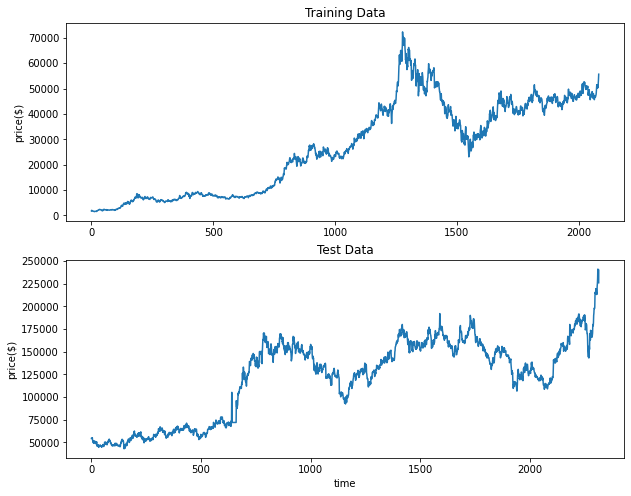

In [3]:
plt.rcParams["figure.figsize"] = (10,8)
plt.subplot(2, 1, 1)
plt.plot(training_set)
plt.title("Training Data")
plt.ylabel('price($)')

plt.subplot(2, 1, 2)
plt.plot(test_set)
plt.title("Test Data")
plt.xlabel('time')
plt.ylabel('price($)')

학습을 위하여 데이터를 0에서 1 사이의 값으로 scaling 해주도록 하겠습니다. 아래 코드를 실행하면 y축 값이 0에서 1 사이의 값으로 바뀌었음을 확인할 수 있습니다.

Text(0, 0.5, 'scaled price($)')

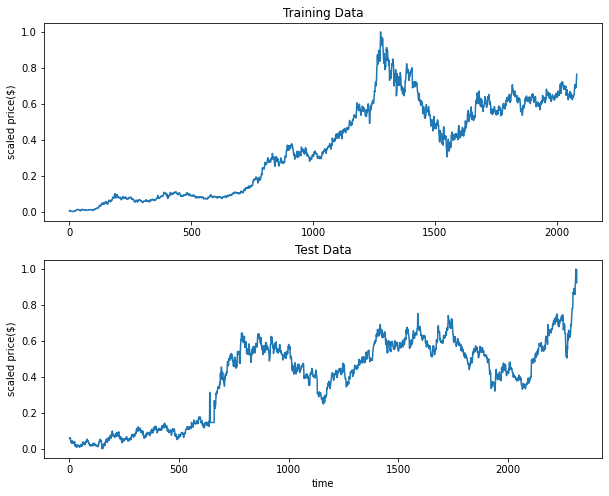

In [4]:
sc1 = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc1.fit_transform(training_set)
sc2 = MinMaxScaler(feature_range=(0,1))
test_set_scaled = sc2.fit_transform(test_set)

plt.rcParams["figure.figsize"] = (10,8)
plt.subplot(2, 1, 1)
plt.plot(training_set_scaled)
plt.title("Training Data")
plt.ylabel('scaled price($)')

plt.subplot(2, 1, 2)
plt.plot(test_set_scaled)
plt.title("Test Data")
plt.xlabel('time')
plt.ylabel('scaled price($)')

이제 학습을 위해 데이터를 일정한 길이의 sequence로 나누도록 하겠습니다. 아래 코드를 통해 길이가 60인 sequence들로 이루어진 X와 그때의 데이터값 Y로 X_train, Y_train, X_test, Y_test 만들 수 있습니다.

In [5]:
X_train = []
Y_train = []
for i in range(60, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    Y_train.append(training_set_scaled[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test = []
Y_test = []
for i in range(60, test_set_scaled.shape[0]):
    X_test.append(test_set_scaled[i-60:i, 0])
    Y_test.append(test_set_scaled[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 2. Simple RNN

이제 RNN 모델을 만들기 위해서 LSTM을 사용하겠습니다. LSTM 한개의 층을 이용해 간단한 모델을 생성해 보겠습니다. 

LSTM은 인자로 

units = (output의 shape을 결정)

Input_shape = (input의 형태를 결정)

return_sequences = (output의 형태를 최종출력과 시퀸스 중 선택)

 아래와 같이 레이어를 구성해 보세요.

| Layer (type) | Output Shape | Param # |
|------|------|------|
| LSTM | (None, 5) | 480 |
| Dense | (None, 1) | 11 |

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model_LSTM = Sequential()

model_LSTM.add(LSTM(5, input_shape = (60,1), return_sequences=False))
model_LSTM.add(Dense(1))

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5)                 140       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


아래와 같은 조건은로 학습을 시작합니다.

In [7]:
model_LSTM.compile(optimizer = 'adam', loss = 'mean_squared_error')
model_LSTM.fit(X_train, Y_train, epochs = 10, batch_size = 128)

Epoch 1/10
16/16 [==============================] - 2s 5ms/step - loss: 0.1980
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.1398
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0958
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0629
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0406
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0279
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0221
Epoch 8/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0189
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 10/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0127


In [8]:
predicted_X_train = model_LSTM.predict(X_train)
predicted_X_train = sc1.inverse_transform(predicted_X_train)

predcited_X_test = model_LSTM.predict(X_test)
predcited_X_test = sc2.inverse_transform(predcited_X_test)

mean_train_error = np.average(np.abs(training_set[59:-1,:] - predicted_X_train))
mean_test_error = np.average(np.abs(test_set[59:-1,:] - predcited_X_test))


print("평균 training error:", mean_train_error)
print("평균 test error:",mean_test_error)

평균 training error: 6417.546384305101
평균 test error: 13806.943772519402


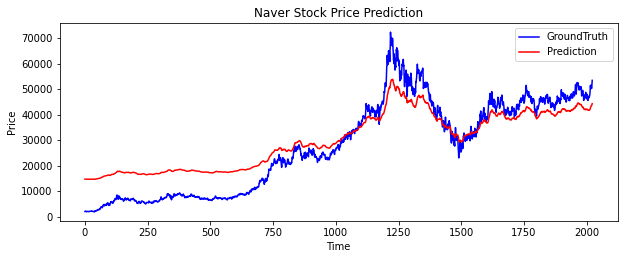

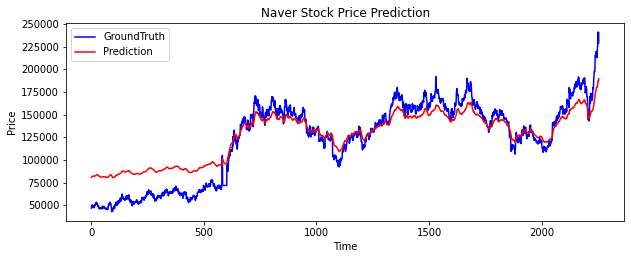

In [9]:
plt.subplot(2, 1, 1)
plt.plot(training_set[59:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predicted_X_train, color = 'red', label = 'Prediction')
plt.title('Naver Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.subplot(2, 1, 2)
plt.plot(test_set[59:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predcited_X_test, color = 'red', label = 'Prediction')
plt.title('Naver Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

수행 결과 예측은 성공했으나 실제 그래프인 파란색 선을 제대로 따라가지 못하는 것을 확인했습니다.

# 3. RNN model

이제 더 깊은 RNN 모델을 만들어보도록 하겠습니다. 아래 모델과 같이 레이어를 구성해 보세요.

| Layer (type) | Output Shape | Param # |
|------|------|------|
| LSTM | (None, 60, 50) | 10400 |
| Dropout | (None, 60, 50) | 0 |
| LSTM | (None, 60, 50) | 20200 |
| Dropout | (None, 60, 50) | 0 |
| LSTM | (None, 60, 50) | 20200 |
| Dropout | (None, 60, 50) | 0 |
| LSTM | (None, 50) | 20200 |
| Dropout | (None, 50) | 0 |
| Dense | (None, 1) | 51 |


In [10]:
model = Sequential()
### START CODE HERE ###
model.add(LSTM(50, input_shape = (60,1), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(50, input_shape = (60,50), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(50, input_shape = (60,50), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(50, input_shape = (60,50), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))
### END CODE HERE ###

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 50)               

학습을 시작합니다.

In [11]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, Y_train, epochs = 10, batch_size = 128)

Epoch 1/10
16/16 [==============================] - 4s 39ms/step - loss: 0.0519
Epoch 2/10
16/16 [==============================] - 0s 19ms/step - loss: 0.0109
Epoch 3/10
16/16 [==============================] - 0s 17ms/step - loss: 0.0057
Epoch 4/10
16/16 [==============================] - 0s 17ms/step - loss: 0.0056
Epoch 5/10
16/16 [==============================] - 0s 17ms/step - loss: 0.0045
Epoch 6/10
16/16 [==============================] - 0s 17ms/step - loss: 0.0044
Epoch 7/10
16/16 [==============================] - 0s 17ms/step - loss: 0.0044
Epoch 8/10
16/16 [==============================] - 0s 17ms/step - loss: 0.0043
Epoch 9/10
16/16 [==============================] - 0s 18ms/step - loss: 0.0042
Epoch 10/10
16/16 [==============================] - 0s 17ms/step - loss: 0.0041


이제 training data의 prediction 결과와 test data의 prediction 결과를 살펴보겠습니다.

In [12]:
predicted_X_train = model.predict(X_train)
predicted_X_train = sc1.inverse_transform(predicted_X_train)

predcited_X_test = model.predict(X_test)
predcited_X_test = sc2.inverse_transform(predcited_X_test)

mean_train_error = np.average(np.abs(training_set[59:-1,:] - predicted_X_train))
mean_test_error = np.average(np.abs(test_set[59:-1,:] - predcited_X_test))


print("평균 training error:", mean_train_error)
print("평균 test error:",mean_test_error)

평균 training error: 1687.8785621842947
평균 test error: 6185.530683550443


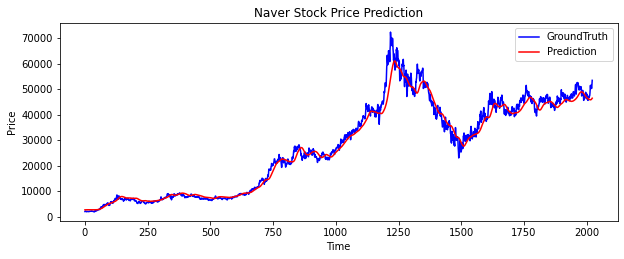

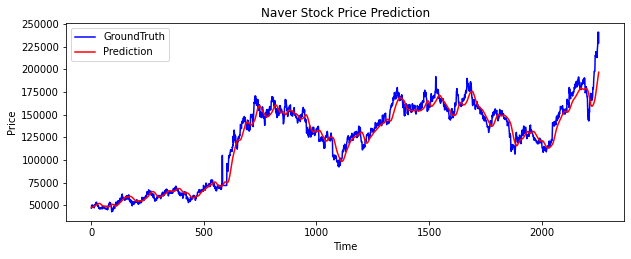

In [13]:
plt.subplot(2, 1, 1)
plt.plot(training_set[59:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predicted_X_train, color = 'red', label = 'Prediction')
plt.title('Naver Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.subplot(2, 1, 2)
plt.plot(test_set[59:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predcited_X_test, color = 'red', label = 'Prediction')
plt.title('Naver Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

수행결과 첫번째 모델보다 더 좋은 성능을 보이는 것을 확인했습니다.

# 4. Model save, Load
완성된 모델을 저장하고 불러와서 결과를 확인하는 방법을 보겠습니다. 사용되는 명령어는 save, load_model입니다.

In [14]:
# from google.colab import drive
# drive.mount('/content/drive')
# ! pwd

In [15]:
import tensorflow as tf
from keras.models import save_model, load_model

# model.save('drive/MyDrive/Recent_model.h5')

In [16]:
recent_model = load_model('drive/MyDrive/Recent_model.h5')

predicted_X_train = recent_model.predict(X_train)
predicted_X_train = sc1.inverse_transform(predicted_X_train)

predcited_X_test = recent_model.predict(X_test)
predcited_X_test = sc2.inverse_transform(predcited_X_test)

mean_train_error = np.average(np.abs(training_set[59:-1,:] - predicted_X_train))
mean_test_error = np.average(np.abs(test_set[59:-1,:] - predcited_X_test))


print("평균 training error:", mean_train_error)
print("평균 test error:",mean_test_error)

평균 training error: 1520.9944292974542
평균 test error: 5788.791243417406


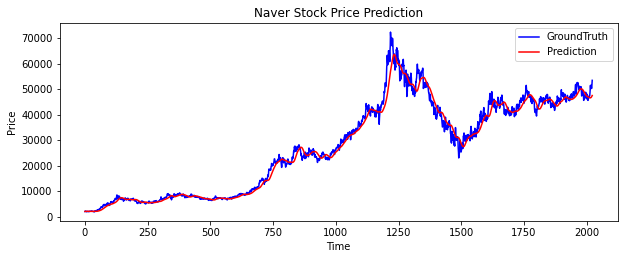

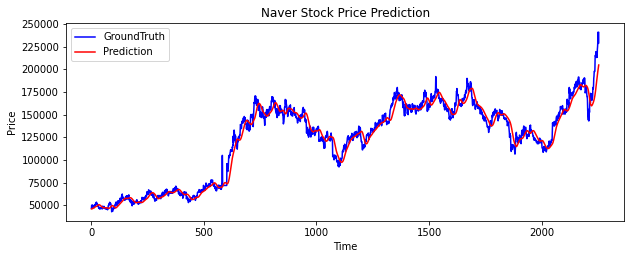

In [17]:
plt.subplot(2, 1, 1)
plt.plot(training_set[59:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predicted_X_train, color = 'red', label = 'Prediction')
plt.title('Naver Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.subplot(2, 1, 2)
plt.plot(test_set[59:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predcited_X_test, color = 'red', label = 'Prediction')
plt.title('Naver Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

기존 모델인 model과 불러온 모델 recent_model이 동일한 것을 확인할 수 있었습니다.

# 5. Test Problem

Problem: 이번에는 종목을 바꿔서 Intel(종목코드 INTC) 주식 2000년 1월 1일부터 2010년 12월 31일까지 주가를 학습데이터로 활용하고 2011년 1월 1일부터 2020년 5월 22일까지 주가를 테스트데이터로 활용해서 주가를 예측해 보세요. 이번 과제는 얼마나 잘 예측하는지 랭킹을 매겨서 공개할 예정입니다. 여러분만의 획기적인 주가 예측 모델을 기대해 봅니다.

여러분들의 모델을 평가하기 위해서 생성한 모델을 "이름_학번.h5"로 저장해주세요. 과제를 제출하실 때는 현재 코드를 작성한 "이름_학번.ipynb" , 보고서, "이름_학번.h5"를 압축해서 "이름_학번.zip"로 업로드 해주시길 바랍니다.

파일의 용량이 너무 큰 경우 hcw511@naver.com으로 보내주시면 됩니다.

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import FinanceDataReader as fdr
import tensorflow as tf

In [19]:
### START CODE HERE ###
df_train = pdr.DataReader('INTC', 'yahoo', datetime(2000,1,1), datetime(2010,12,31))
df_test = pdr.DataReader('INTC', 'yahoo', datetime(2011,1,1), datetime(2020,5,22)) 
### END CODE HERE ###

training_set = df_train.iloc[:, 3:4].values
test_set = df_test.iloc[:, 3:4].values

assert training_set.shape == (2768,1)
assert test_set.shape == (2364,1)

Text(0, 0.5, 'price($)')

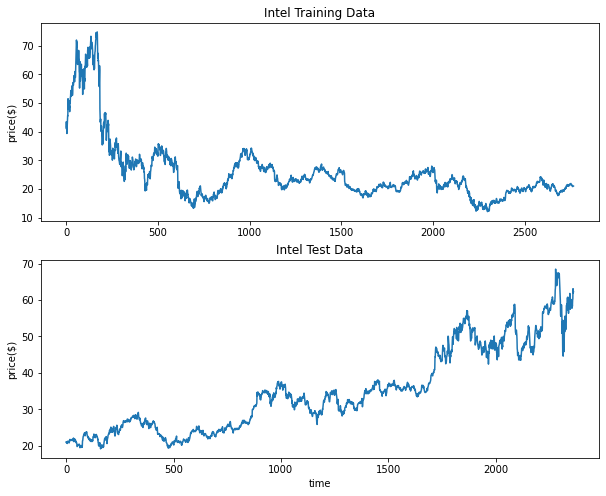

In [20]:
plt.rcParams["figure.figsize"] = (10,8)
plt.subplot(2, 1, 1)
plt.plot(training_set)
plt.title("Intel Training Data")
plt.ylabel('price($)')

plt.subplot(2, 1, 2)
plt.plot(test_set)
plt.title("Intel Test Data")
plt.xlabel('time')
plt.ylabel('price($)')

Text(0, 0.5, 'scaled price($)')

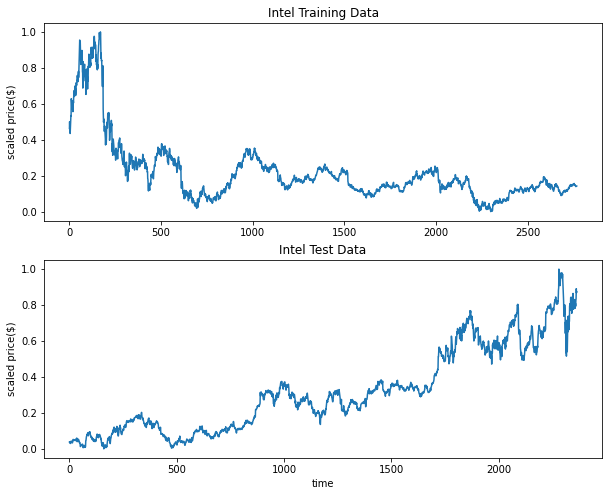

In [21]:
sc1 = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc1.fit_transform(training_set)
sc2 = MinMaxScaler(feature_range=(0,1))
test_set_scaled = sc2.fit_transform(test_set)

plt.rcParams["figure.figsize"] = (10,8)
plt.subplot(2, 1, 1)
plt.plot(training_set_scaled)
plt.title("Intel Training Data")
plt.ylabel('scaled price($)')

plt.subplot(2, 1, 2)
plt.plot(test_set_scaled)
plt.title("Intel Test Data")
plt.xlabel('time')
plt.ylabel('scaled price($)')

In [22]:
X_train = []
Y_train = []

for i in range(60, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    Y_train.append(training_set_scaled[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test = []
Y_test = []
for i in range(60, test_set_scaled.shape[0]):
    X_test.append(test_set_scaled[i-60:i, 0])
    Y_test.append(test_set_scaled[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [23]:
print(X_train.shape[1])

60


## GRU

In [24]:
from keras.models import Sequential 
from keras.layers import Dense, SimpleRNN, GRU, LayerNormalization
from tensorflow.keras.optimizers import SGD 

### My Layer 1

In [36]:
sequence_length = X_train.shape[1]

my_GRU_model = Sequential()

my_GRU_model.add(GRU(units = 64, 
                 return_sequences = True, 
                 input_shape = (sequence_length,1), 
                 activation = 'relu',
                 recurrent_dropout = 0.1))



my_GRU_model.add(GRU(units = 64,
                 input_shape = (sequence_length,32),
                 activation = 'relu',
                recurrent_dropout = 0.1))



my_GRU_model.add(Dense(units = 1))

my_GRU_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 60, 64)            12864     
                                                                 
 gru_3 (GRU)                 (None, 64)                24960     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________


### Training

In [39]:
with tf.device('/gpu:0'):
    my_GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    my_GRU_model.fit(X_train, Y_train, epochs = 50, batch_size = 128)

Epoch 1/50
22/22 [==============================] - 13s 489ms/step - loss: 4.0431e-04
Epoch 2/50
22/22 [==============================] - 11s 496ms/step - loss: 2.2841e-04
Epoch 3/50
22/22 [==============================] - 11s 495ms/step - loss: 2.1755e-04
Epoch 4/50
22/22 [==============================] - 11s 505ms/step - loss: 2.3270e-04
Epoch 5/50
22/22 [==============================] - 11s 505ms/step - loss: 2.1515e-04
Epoch 6/50
22/22 [==============================] - 11s 506ms/step - loss: 2.1263e-04
Epoch 7/50
22/22 [==============================] - 11s 490ms/step - loss: 2.5595e-04
Epoch 8/50
22/22 [==============================] - 11s 496ms/step - loss: 2.1641e-04
Epoch 9/50
22/22 [==============================] - 11s 504ms/step - loss: 2.0773e-04
Epoch 10/50
22/22 [==============================] - 11s 507ms/step - loss: 2.1377e-04
Epoch 11/50
22/22 [==============================] - 12s 526ms/step - loss: 2.0776e-04
Epoch 12/50
22/22 [==============================] -

In [27]:
# with tf.device('/gpu:0'):
#     model_2.compile(optimizer=RMSprop(), loss='mae')
#     history = model_2.fit(X_train, Y_train, epochs = 100, batch_size = 128)

In [40]:
kernal = sequence_length- 1

predicted_X_train = my_GRU_model.predict(X_train)
predicted_X_train = sc1.inverse_transform(predicted_X_train)

predcited_X_test = my_GRU_model.predict(X_test)
predcited_X_test = sc2.inverse_transform(predcited_X_test)

mean_train_error = np.average(np.abs(training_set[kernal:-1,:] - predicted_X_train))
mean_test_error = np.average(np.abs(test_set[kernal:-1,:] - predcited_X_test))

print("평균 training error:", mean_train_error)
print("평균 test error:",mean_test_error)

평균 training error: 0.15724197377834573
평균 test error: 0.10186965763568878


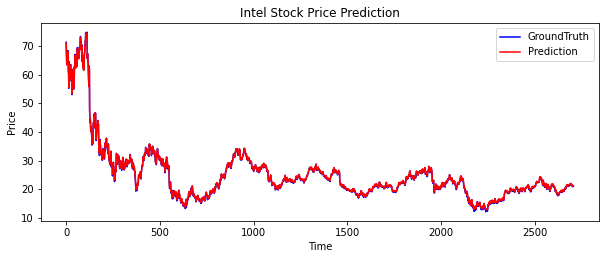

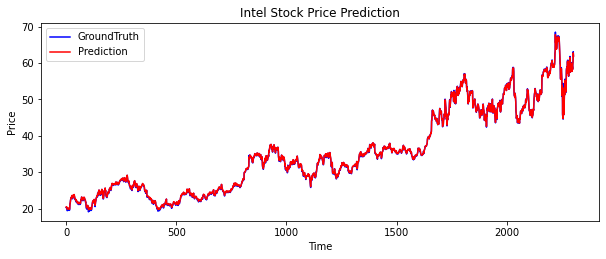

In [42]:
plt.subplot(2, 1, 1)
plt.plot(training_set[59:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predicted_X_train, color = 'red', label = 'Prediction')
plt.title('Intel Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.subplot(2, 1, 2)
plt.plot(test_set[59:-1,:], color = 'blue', label = 'GroundTruth')
plt.plot(predcited_X_test, color = 'red', label = 'Prediction')
plt.title('Intel Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [43]:
import tensorflow as tf
from keras.models import save_model, load_model

my_GRU_model.save('./LeeJaeWon-2020741051.h5')